In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, f1_score, log_loss
from sklearn.metrics import classification_report,confusion_matrix, precision_recall_fscore_support 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn import grid_search, svm
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

df = pd.read_csv('CKD_full.csv')
df.head()

,ID,Race,Gender,Age,Creatinine,Glucose,DBP,SBP,HGB,LDL,Class
0,1,Unknown,Male,70,1.24,6.46,83.17,139.61,13.26,143.59,ckd
1,2,White,Female,71,1.84,9.24,80.46,150.23,13.66,82.42,notckd
2,3,White,Female,57,2.17,6.47,89.22,140.21,15.70,75.28,ckd
3,4,White,Male,74,1.00,6.52,74.86,139.59,13.20,98.25,notckd
4,5,White,Female,50,1.15,9.72,97.39,160.67,12.66,65.91,ckd


In [2]:
#add an estimated Glomerular Filtration Rate (eGFR) calculated based on MDRD equation as new column

def get_GFR(Creatinine, Age, Gender, Race):
        if Creatinine == 0.0 or Age == 0.0:
            return 0
        if Gender == '0' and Race == '2':
            GFR = round(175*(Creatinine)**-1.154 * (Age)**-0.203 * (0.742) * (1.212), 2)
        elif Gender == '0' and Race != '2':
            GFR = round(175*(Creatinine)**-1.154 * (Age)**-0.203 * (0.742), 2)    
        elif Gender != '0' and Race == '2':
            GFR = round(175*(Creatinine)**-1.154 * (Age)**-0.203 * (1.212), 2) 
        else: 
             GFR = round(175*(Creatinine)**-1.154 * (Age)**-0.203, 2) 
        return GFR
                
                
GFR = []
for index, row in df.iterrows():
    GFR.append(get_GFR(row['Creatinine'], row['Age'], row['Gender'], row['Race']))

df['GFR'] = pd.Series(GFR, index=df.index)
df.head()

,ID,Race,Gender,Age,Creatinine,Glucose,DBP,SBP,HGB,LDL,Class,GFR
0,1,Unknown,Male,70,1.24,6.46,83.17,139.61,13.26,143.59,ckd,57.63
1,2,White,Female,71,1.84,9.24,80.46,150.23,13.66,82.42,notckd,36.44
2,3,White,Female,57,2.17,6.47,89.22,140.21,15.70,75.28,ckd,31.50
3,4,White,Male,74,1.00,6.52,74.86,139.59,13.20,98.25,notckd,73.04
4,5,White,Female,50,1.15,9.72,97.39,160.67,12.66,65.91,ckd,67.31


In [3]:
df['Class'] = df['Class'].replace(to_replace={'ckd':1.0,'notckd':0.0})

In [4]:
df[['Gender']] = df[['Gender']].replace(to_replace={'Male':1,'Female':0})

In [5]:
df[['Race']] = df[['Race']].replace(to_replace={'White':1,'Black':2,'Hispanic':3,'Asian':4,'Unknown':np.nan})

In [7]:
def reorder_columns(columns, first_cols=[], last_cols=[], drop_cols=[]):
    columns = list(set(columns) - set(first_cols))
    columns = list(set(columns) - set(drop_cols))
    columns = list(set(columns) - set(last_cols))
    new_order = first_cols + columns + last_cols
    return new_order

my_list = df.columns.tolist()
reordered_cols = reorder_columns(my_list, first_cols=['Race', 'Gender', 'Age'], last_cols=['GFR', 'Class'], drop_cols=['ID', 'DBP', 'SBP', 'LDL', 'HGB'])
df = df[reordered_cols]
df.head()

,Race,Gender,Age,Glucose,Creatinine,GFR,Class
0,NaN,1,70,6.46,1.24,57.63,1.0
1,1.0,0,71,9.24,1.84,36.44,0.0
2,1.0,0,57,6.47,2.17,31.50,1.0
3,1.0,1,74,6.52,1.00,73.04,0.0
4,1.0,0,50,9.72,1.15,67.31,1.0


In [8]:
df = df.dropna(axis=0)
df['Class'].value_counts()

0.0    184
1.0     90
Name: Class, dtype: int64

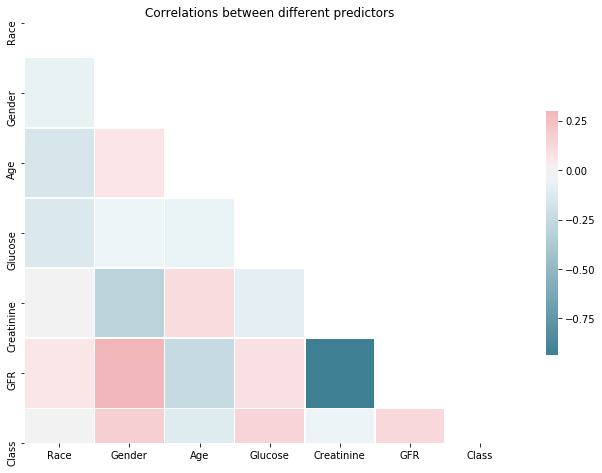

In [9]:
corr_df = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations between different predictors')
plt.show()

In [11]:
df.describe()


,Race,Gender,Age,Glucose,Creatinine,GFR,Class
count,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000
mean,1.324818,0.419708,70.343066,6.703139,1.315949,57.334599,0.328467
std,0.803133,0.494414,9.072309,1.435899,0.306628,14.779607,0.470515
min,1.000000,0.000000,46.000000,4.660000,0.770000,22.390000,0.000000
25%,1.000000,0.000000,64.000000,5.792500,1.110000,46.012500,0.000000
50%,1.000000,0.000000,71.500000,6.385000,1.270000,56.000000,0.000000
75%,1.000000,1.000000,77.000000,7.297500,1.500000,65.407500,1.000000
max,4.000000,1.000000,85.000000,15.990000,2.800000,102.040000,1.000000


In [12]:
df.corr()

,Race,Gender,Age,Glucose,Creatinine,GFR,Class
Race,1.000000,-0.067840,-0.164660,-0.138613,-0.037327,0.059803,-0.021651
Gender,-0.067840,1.000000,0.067411,-0.040147,-0.296086,0.322286,0.176770
Age,-0.164660,0.067411,1.000000,-0.057316,0.116364,-0.243070,-0.117455
Glucose,-0.138613,-0.040147,-0.057316,1.000000,-0.084095,0.080616,0.150061
Creatinine,-0.037327,-0.296086,0.116364,-0.084095,1.000000,-0.935885,-0.046346
GFR,0.059803,0.322286,-0.243070,0.080616,-0.935885,1.000000,0.129124
Class,-0.021651,0.176770,-0.117455,0.150061,-0.046346,0.129124,1.000000


In [13]:
X = df.drop("Class", axis=1)
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
classifiers = [
    KNeighborsClassifier(5),
    SVC(C=.1, degree=1, kernel='poly', probability=True),
    NuSVC(nu=.1, degree=1, kernel='poly', probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    LogisticRegression()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", 'Log Loss']
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    try:
        print('****Results****')
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        print("Accuracy: {:.4%}".format(acc))
#         print("accuracy_score: \n",accuracy_score(y_test, train_predictions))
        print("precision_score: \n",precision_score(y_test, train_predictions))
        print("f1_score: \n",f1_score(y_test, train_predictions))
#         print("classification_report: \n",classification_report(y_test, train_predictions))
        print("confusion_matrix: \n",confusion_matrix(y_test, train_predictions))
        print("log_loss: \n",log_loss(y_test, train_predictions))
        log_entry = pd.DataFrame([[name, acc*100, log_loss(y_test, train_predictions)]], columns=log_cols)
        log = log.append(log_entry)
    except Exception as e:
        print (e)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 52.7273%
precision_score: 
 0.21428571428571427
f1_score: 
 0.1875
confusion_matrix: 
 [[26 11]
 [15  3]]
log_loss: 
 16.327581487989274
SVC
****Results****
Accuracy: 67.2727%
precision_score: 
 0.0
f1_score: 
 0.0
confusion_matrix: 
 [[37  0]
 [18  0]]
log_loss: 
 11.303599547425314
NuSVC
****Results****


C:\Users\MED\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\MED\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MED\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MED\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' t

Accuracy: 56.3636%
precision_score: 
 0.35
f1_score: 
 0.36842105263157887
confusion_matrix: 
 [[24 13]
 [11  7]]
log_loss: 
 15.071655058989979
DecisionTreeClassifier
****Results****
Accuracy: 58.1818%
precision_score: 
 0.3684210526315789
f1_score: 
 0.37837837837837834
confusion_matrix: 
 [[25 12]
 [11  7]]
log_loss: 
 14.443662768220149
RandomForestClassifier
****Results****
Accuracy: 61.8182%
precision_score: 
 0.4
f1_score: 
 0.3636363636363636
confusion_matrix: 
 [[28  9]
 [12  6]]
log_loss: 
 13.187663648545383
AdaBoostClassifier
****Results****
Accuracy: 63.6364%
precision_score: 
 0.4166666666666667
f1_score: 
 0.33333333333333337
confusion_matrix: 
 [[30  7]
 [13  5]]
log_loss: 
 12.559656819640454
GradientBoostingClassifier
****Results****
Accuracy: 70.9091%
precision_score: 
 0.6
f1_score: 
 0.42857142857142855
confusion_matrix: 
 [[33  4]
 [12  6]]
log_loss: 
 10.047702194696212
GaussianNB
****Results****
Accuracy: 67.2727%
precision_score: 
 0.5
f1_score: 
 0.30769230769

C:\Users\MED\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\MED\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
